In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow import keras
import warnings

In [14]:
warnings.filterwarnings('ignore')

In [15]:
def load_data():
    return pd.read_csv('./data/train.new.csv')
    

In [16]:
load_data()['eyesight(right)'].unique()

array([0.6, 0.7, 0.5, 1.2, 1. , 0.9, 1.5, 0.8, 0.3, 0.2, 0.1, 2. , 0.4,
       9.9, 1.6, 1.4, 1.3])

In [17]:
genders = {'M' : 0, 'F' : 1}

In [31]:
def get_selected_data():
    df = load_data()
    df = df.dropna()
    df = df.drop('id', axis=1)
    df = df.drop('country', axis=1)
    df = df.replace(genders)
    df['imc'] = df['weight(kg)'] / (df['height(cm)'] / 100) ** 2
    #make some categorical variables
    df['new_age'] = pd.cut(df['age'], 5, labels=False)
    df['eyesight(right)'] = pd.cut(df['eyesight(right)'], 5, labels=False)
    df['eyesight(left)'] = pd.cut(df['eyesight(left)'], 5, labels=False)
    #make combinations of categorical variables
    df['age_bmi'] = df['new_age'] * df['imc']
    X = df.drop('smoking', axis=1)
    y = df['smoking']
    X = X.drop('age', axis=1)
    return X, y

In [32]:
X,y = get_selected_data()
X.columns

Index(['sex', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'imc', 'new_age', 'age_bmi'],
      dtype='object')

In [33]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

pipe = Pipeline([('scaler', RobustScaler())])
pipe.fit(X_train)
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)



In [34]:
X_train.shape

(109300, 25)

In [37]:
epochs = 100
batch_size = 16
opt = keras.optimizers.Adam(learning_rate = 0.0001)

In [38]:

model = keras.Sequential()
model.add(keras.layers.Input(shape = (X_train.shape[1],)))
model.add(keras.layers.Dense(526,activation = 'relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(128,activation ='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(32,activation ='relu'))
model.add(keras.layers.Dense(1,activation = 'relu'))

In [39]:
model.compile(optimizer = opt,loss = 'binary_crossentropy',metrics = ['accuracy'])
history = model.fit(X_train,y_train,epochs = epochs,batch_size = batch_size,validation_data = (X_test,y_test))

Epoch 1/100
6832/6832 [==============================] - 10s 1ms/step - loss: 3.2892 - accuracy: 0.6973 - val_loss: 2.3102 - val_accuracy: 0.7346
Epoch 2/100
6832/6832 [==============================] - 9s 1ms/step - loss: 2.4447 - accuracy: 0.7043 - val_loss: 1.4057 - val_accuracy: 0.7092
Epoch 3/100
6832/6832 [==============================] - 9s 1ms/step - loss: 1.7449 - accuracy: 0.6928 - val_loss: 1.0605 - val_accuracy: 0.6677
Epoch 4/100
6832/6832 [==============================] - 10s 1ms/step - loss: 1.3089 - accuracy: 0.6796 - val_loss: 0.7713 - val_accuracy: 0.6841
Epoch 5/100
6832/6832 [==============================] - 9s 1ms/step - loss: 1.0550 - accuracy: 0.6752 - val_loss: 0.7845 - val_accuracy: 0.6834
Epoch 6/100
6832/6832 [==============================] - 9s 1ms/step - loss: 0.9307 - accuracy: 0.6853 - val_loss: 0.7303 - val_accuracy: 0.6790
Epoch 7/100
6832/6832 [==============================] - 9s 1ms/step - loss: 0.8393 - accuracy: 0.6978 - val_loss: 0.6488 - val_

In [40]:
model.evaluate(X_test,y_test)

854/854 [==============================] - 1s 676us/step - loss: 0.4657 - accuracy: 0.7761


[0.4656772017478943, 0.7761390805244446]

In [26]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Accuracy')

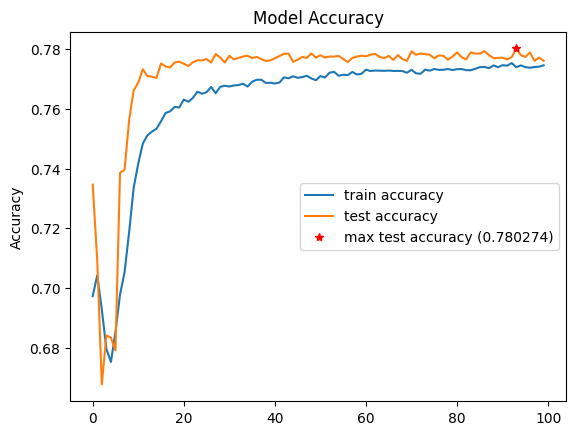

In [41]:
df_history = pd.DataFrame(history.history)
plt.plot(df_history['accuracy'])
plt.plot(df_history['val_accuracy'])
#Show max of val_accuracy and show value
plt.plot(df_history['val_accuracy'].idxmax(), df_history['val_accuracy'].max(), 'r*')
plt.legend(['train accuracy', 'test accuracy', f'max test accuracy ({round(df_history["val_accuracy"].max(),ndigits=6)})'], loc='right')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')

In [42]:
#export all
model.save('./model_best_score.h5')
df_history.to_csv('./history.csv', index=False)